# QUORA QUESTION PAIR SIMILARITY WITH TFIDF

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. TRAIN-TEST SPLIT

1. seperate the text data


2. Split the data into train and test


3. Seperate the text data and vectorize it


4. Then join it with data that has advanced features

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [3]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [4]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [5]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2', 'is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfnlp[['id', 'question1', 'question2']]
y_true = dfnlp.is_duplicate

In [6]:
print(df1.columns)
print(df1.shape)
df1.head()

Index(['id', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')
(404290, 16)


,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [7]:
print(df2.columns)
print(df2.shape)
df2.head()

Index(['id', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       'freq_q1-q2'],
      dtype='object')
(404290, 12)


,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [27]:
df3 = df3.fillna(' ')
print(df3.columns)
print(df3.shape)
df3.head()

Index(['id', 'question1', 'question2'], dtype='object')
(404290, 3)


,id,question1,question2
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,3,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...
4,4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water


In [28]:
df_text = pd.DataFrame()
df_text['Text'] = df3.question1 + ' ' + df3.question2

In [29]:
print(df_text.columns)
print(df_text.shape)
df_text.head()

Index(['Text'], dtype='object')
(404290, 1)


,Text
0,what is the step by step guide to invest in sh...
1,what is the story of kohinoor koh i noor dia...
2,how can i increase the speed of my internet co...
3,why am i mentally very lonely how can i solve...
4,which one dissolve in water quikly sugar salt...


In [30]:
df2['id']=df1['id']
df_text['id']=df1['id']
df_temp  = df1.merge(df2, on='id',how='left')

In [31]:
df_temp = df_temp.merge(df_text, on='id', how='left')
print(df_temp.columns)
df_temp.head()

Index(['id', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'Text'],
      dtype='object')


,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,Text
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,...,66,57,14,12,10.0,23.0,0.434783,2,0,what is the step by step guide to invest in sh...
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,...,51,88,8,13,4.0,20.0,0.200000,5,3,what is the story of kohinoor koh i noor dia...
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,...,73,59,14,10,4.0,24.0,0.166667,2,0,how can i increase the speed of my internet co...
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,...,50,65,11,9,0.0,19.0,0.000000,2,0,why am i mentally very lonely how can i solve...
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,...,76,39,13,7,2.0,20.0,0.100000,4,2,which one dissolve in water quikly sugar salt...


In [32]:
y_true = dfnlp.is_duplicate

In [33]:
X = df_temp.head(100000)
y = y_true.head(100000)

In [34]:
print(X.shape)
print(y.shape)

(100000, 28)
(100000,)


In [36]:
#train-test splitting
X_train_temp, X_test_temp, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=12)

In [37]:
print(X_train_temp.shape)
print(y_train.shape)
print(X_test_temp.shape)
print(y_test.shape)

(80000, 28)
(80000,)
(20000, 28)
(20000,)


# 2. TFIDF VECTORIZING TEXT DATA

In [35]:
vect = TfidfVectorizer()

In [40]:
tfidf_text_X_train = vect.fit_transform(X_train_temp['Text'])

In [48]:
tfidf_text_X_train

<80000x41401 sparse matrix of type '<class 'numpy.float64'>'
	with 1233358 stored elements in Compressed Sparse Row format>

In [42]:
tfidf_text_X_test = vect.transform(X_test_temp['Text'])

In [49]:
tfidf_text_X_test

<20000x41401 sparse matrix of type '<class 'numpy.float64'>'
	with 304774 stored elements in Compressed Sparse Row format>

In [45]:
X_train_1 = X_train_temp.drop('Text', axis=1)
X_test_1 = X_test_temp.drop('Text', axis=1)

In [92]:
X_train_1.shape

(80000, 27)

In [93]:
X_test_1.shape

(20000, 27)

In [51]:
#stacking tfidf vectorized text data & other advanvanced nlp features like ratio
X_train = hstack((X_train_1,tfidf_text_X_train))
X_test = hstack((X_test_1,tfidf_text_X_test))

In [95]:
print('X_train :',X_train.shape)
print('X_test :',X_test.shape)

X_train : (80000, 41428)
X_test : (20000, 41428)


In [57]:
# Standardizing the data
from sklearn.preprocessing import StandardScaler
scale = StandardScaler(with_mean=False)
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

# 3. Machine Learning Models

In [63]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# 3.1 Logistic Regression with TFIDF

For values of alpha =  1e-05 The log loss is: 0.5334702978650625
For values of alpha =  0.0001 The log loss is: 0.5318544476928626
For values of alpha =  0.001 The log loss is: 0.5356305533461118
For values of alpha =  0.01 The log loss is: 0.5109246376180082
For values of alpha =  0.1 The log loss is: 0.44328160929829463
For values of alpha =  1 The log loss is: 0.4534260664278418
For values of alpha =  10 The log loss is: 0.5150349182643443


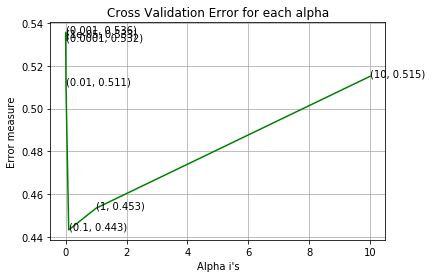

For values of best alpha =  0.1 The train log loss is: 0.311506376997774
For values of best alpha =  0.1 The test log loss is: 0.44328160929829463
Total number of data points : 20000


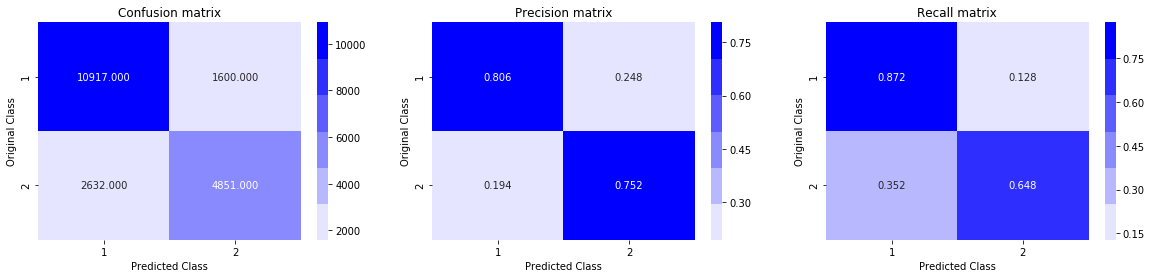

In [64]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_, y_train)
    predict_y = sig_clf.predict_proba(X_test_)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_, y_train)

predict_y = sig_clf.predict_proba(X_train_)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 3.2 Linear SVM with TFIDF

For values of alpha =  1e-05 The log loss is: 0.5356218417894919
For values of alpha =  0.0001 The log loss is: 0.5351194839494243
For values of alpha =  0.001 The log loss is: 0.532300638438738
For values of alpha =  0.01 The log loss is: 0.5132107309888126
For values of alpha =  0.1 The log loss is: 0.45950008696797395
For values of alpha =  1 The log loss is: 0.4451276981150781
For values of alpha =  10 The log loss is: 0.5517164546767706


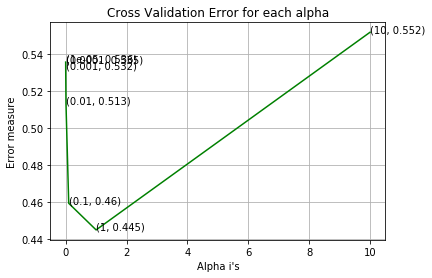

For values of best alpha =  1 The train log loss is: 0.36867697250115267
For values of best alpha =  1 The test log loss is: 0.4534260664278418
Total number of data points : 20000


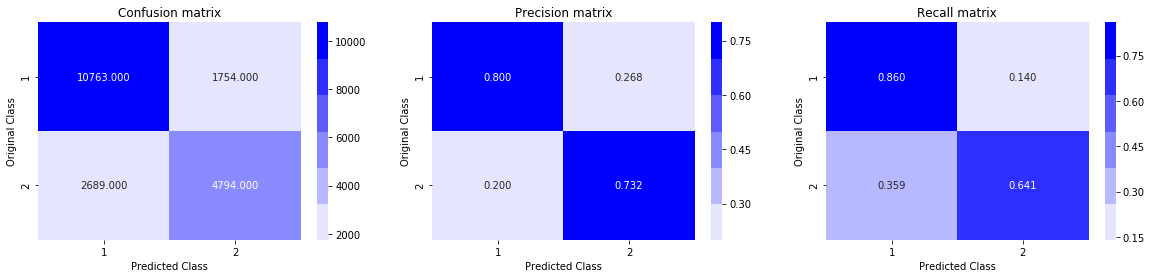

In [65]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_, y_train)
    predict_y = sig_clf.predict_proba(X_test_)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_, y_train)

predict_y = sig_clf.predict_proba(X_train_)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 3.3 XGBoost with TFIDF

In [85]:
def XGB_best_params (X_train, y_train) :
    clf = XGBClassifier(n_jobs = -1)
    param_grid = {'learning_rate' : np.linspace(0, 1, 6),
                  'n_estimators' : [10, 30, 50, 100, 200, 500, 1000, 1200],
                  'max_depth' : list(range(1,7))}
    cv = 5
    rand_cv = RandomizedSearchCV(clf, param_grid, scoring='neg_log_loss', verbose=1, cv=cv, n_jobs=-1)
    rand_cv.fit(X_train, y_train)
    print('LOG-LOSS:', rand_cv.best_params_)
    print('best Score:', rand_cv.best_score_)
    #accessing cv_results
    cv_results = pd.DataFrame(rand_cv.cv_results_)
    plot_data_1 = cv_results[['param_n_estimators', 'mean_test_score']].sort_values('param_n_estimators')
    #Function for cv_error vs alpha plot
    plt.figure(figsize=(10,6))
    plt.xlabel('Hyperparams')
    plt.ylabel('Best Score')
    plt.plot(plot_data_1['param_n_estimators'], -plot_data_1['mean_test_score'], marker='o', markerfacecolor='green', markersize=10, label='n_estimators')
    plt.legend(loc='upper left')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.6min finished


LOG-LOSS: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2}
best Score: -0.31938490364894384


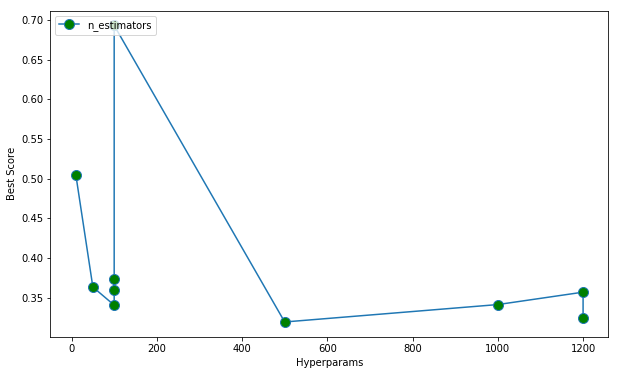

In [86]:
XGB_best_params(X_train, y_train)

In [97]:
#lets viuallise the eval result
clf = XGBClassifier(learning_rate=0.2, n_estimators=500, max_depth=4, njobs=-1)
clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='logloss',
        verbose=True)
y_pred = clf.predict(X_test)
fi = clf.feature_importances_

[0]	validation_0-logloss:0.617872	validation_1-logloss:0.617761
[1]	validation_0-logloss:0.563976	validation_1-logloss:0.564293
[2]	validation_0-logloss:0.523963	validation_1-logloss:0.524828
[3]	validation_0-logloss:0.495163	validation_1-logloss:0.495894
[4]	validation_0-logloss:0.471689	validation_1-logloss:0.472717
[5]	validation_0-logloss:0.454709	validation_1-logloss:0.455807
[6]	validation_0-logloss:0.439191	validation_1-logloss:0.44046
[7]	validation_0-logloss:0.428588	validation_1-logloss:0.430075
[8]	validation_0-logloss:0.418899	validation_1-logloss:0.420731
[9]	validation_0-logloss:0.410939	validation_1-logloss:0.412635
[10]	validation_0-logloss:0.404258	validation_1-logloss:0.406137
[11]	validation_0-logloss:0.398847	validation_1-logloss:0.401047
[12]	validation_0-logloss:0.394228	validation_1-logloss:0.39653
[13]	validation_0-logloss:0.390694	validation_1-logloss:0.393188
[14]	validation_0-logloss:0.38677	validation_1-logloss:0.389431
[15]	validation_0-logloss:0.383814	val

[127]	validation_0-logloss:0.315163	validation_1-logloss:0.334372
[128]	validation_0-logloss:0.314934	validation_1-logloss:0.334264
[129]	validation_0-logloss:0.314788	validation_1-logloss:0.334248
[130]	validation_0-logloss:0.314466	validation_1-logloss:0.334112
[131]	validation_0-logloss:0.314231	validation_1-logloss:0.334038
[132]	validation_0-logloss:0.313985	validation_1-logloss:0.333899
[133]	validation_0-logloss:0.313769	validation_1-logloss:0.333796
[134]	validation_0-logloss:0.31361	validation_1-logloss:0.333837
[135]	validation_0-logloss:0.313431	validation_1-logloss:0.333828
[136]	validation_0-logloss:0.313198	validation_1-logloss:0.333757
[137]	validation_0-logloss:0.312979	validation_1-logloss:0.333617
[138]	validation_0-logloss:0.312733	validation_1-logloss:0.333519
[139]	validation_0-logloss:0.312598	validation_1-logloss:0.333433
[140]	validation_0-logloss:0.312099	validation_1-logloss:0.333149
[141]	validation_0-logloss:0.311879	validation_1-logloss:0.333077
[142]	valid

[252]	validation_0-logloss:0.292032	validation_1-logloss:0.32505
[253]	validation_0-logloss:0.291897	validation_1-logloss:0.324976
[254]	validation_0-logloss:0.291786	validation_1-logloss:0.324957
[255]	validation_0-logloss:0.291581	validation_1-logloss:0.324901
[256]	validation_0-logloss:0.291174	validation_1-logloss:0.32476
[257]	validation_0-logloss:0.290996	validation_1-logloss:0.324766
[258]	validation_0-logloss:0.290914	validation_1-logloss:0.324726
[259]	validation_0-logloss:0.290788	validation_1-logloss:0.324695
[260]	validation_0-logloss:0.290676	validation_1-logloss:0.324679
[261]	validation_0-logloss:0.290561	validation_1-logloss:0.324645
[262]	validation_0-logloss:0.290442	validation_1-logloss:0.324649
[263]	validation_0-logloss:0.290342	validation_1-logloss:0.324635
[264]	validation_0-logloss:0.290219	validation_1-logloss:0.324593
[265]	validation_0-logloss:0.290043	validation_1-logloss:0.324565
[266]	validation_0-logloss:0.289897	validation_1-logloss:0.32455
[267]	validat

[377]	validation_0-logloss:0.277093	validation_1-logloss:0.320906
[378]	validation_0-logloss:0.277006	validation_1-logloss:0.320865
[379]	validation_0-logloss:0.276915	validation_1-logloss:0.320826
[380]	validation_0-logloss:0.276858	validation_1-logloss:0.320791
[381]	validation_0-logloss:0.2768	validation_1-logloss:0.320817
[382]	validation_0-logloss:0.27669	validation_1-logloss:0.320787
[383]	validation_0-logloss:0.276623	validation_1-logloss:0.320767
[384]	validation_0-logloss:0.276528	validation_1-logloss:0.320729
[385]	validation_0-logloss:0.276456	validation_1-logloss:0.320713
[386]	validation_0-logloss:0.276402	validation_1-logloss:0.320671
[387]	validation_0-logloss:0.276307	validation_1-logloss:0.320666
[388]	validation_0-logloss:0.276242	validation_1-logloss:0.320657
[389]	validation_0-logloss:0.276084	validation_1-logloss:0.320629
[390]	validation_0-logloss:0.275681	validation_1-logloss:0.320363
[391]	validation_0-logloss:0.275582	validation_1-logloss:0.320317
[392]	validat

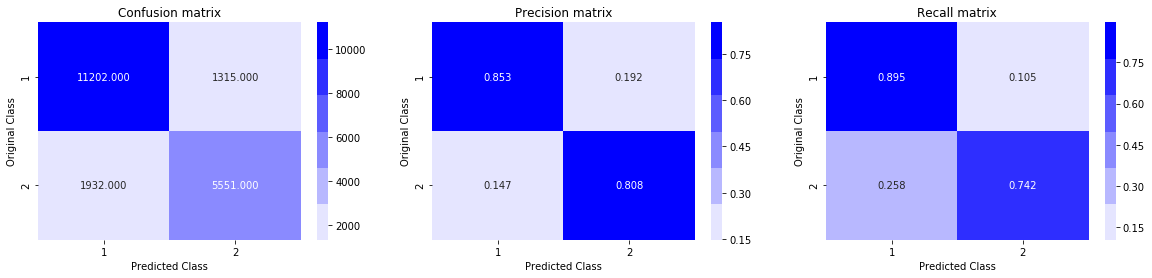

In [96]:
plot_confusion_matrix(y_test, y_pred)

In [98]:
evals_result = clf.evals_result()
evals_result #to find the minimum of train and test log loss

{'validation_0': {'logloss': [0.617872,
   0.563976,
   0.523963,
   0.495163,
   0.471689,
   0.454709,
   0.439191,
   0.428588,
   0.418899,
   0.410939,
   0.404258,
   0.398847,
   0.394228,
   0.390694,
   0.38677,
   0.383814,
   0.381428,
   0.378998,
   0.37682,
   0.374589,
   0.373194,
   0.37152,
   0.369454,
   0.367397,
   0.366316,
   0.365188,
   0.363532,
   0.362404,
   0.361172,
   0.360184,
   0.358872,
   0.358125,
   0.356853,
   0.355767,
   0.35469,
   0.353936,
   0.353229,
   0.352221,
   0.351635,
   0.350974,
   0.350158,
   0.34962,
   0.34912,
   0.348537,
   0.348075,
   0.347597,
   0.346515,
   0.34525,
   0.344648,
   0.343946,
   0.343468,
   0.342783,
   0.342283,
   0.34188,
   0.341409,
   0.340814,
   0.340345,
   0.340032,
   0.339492,
   0.339047,
   0.338741,
   0.338247,
   0.337965,
   0.33763,
   0.337228,
   0.336939,
   0.336505,
   0.335784,
   0.335348,
   0.3349,
   0.334457,
   0.333813,
   0.333389,
   0.333105,
   0.332808,
   0.3324

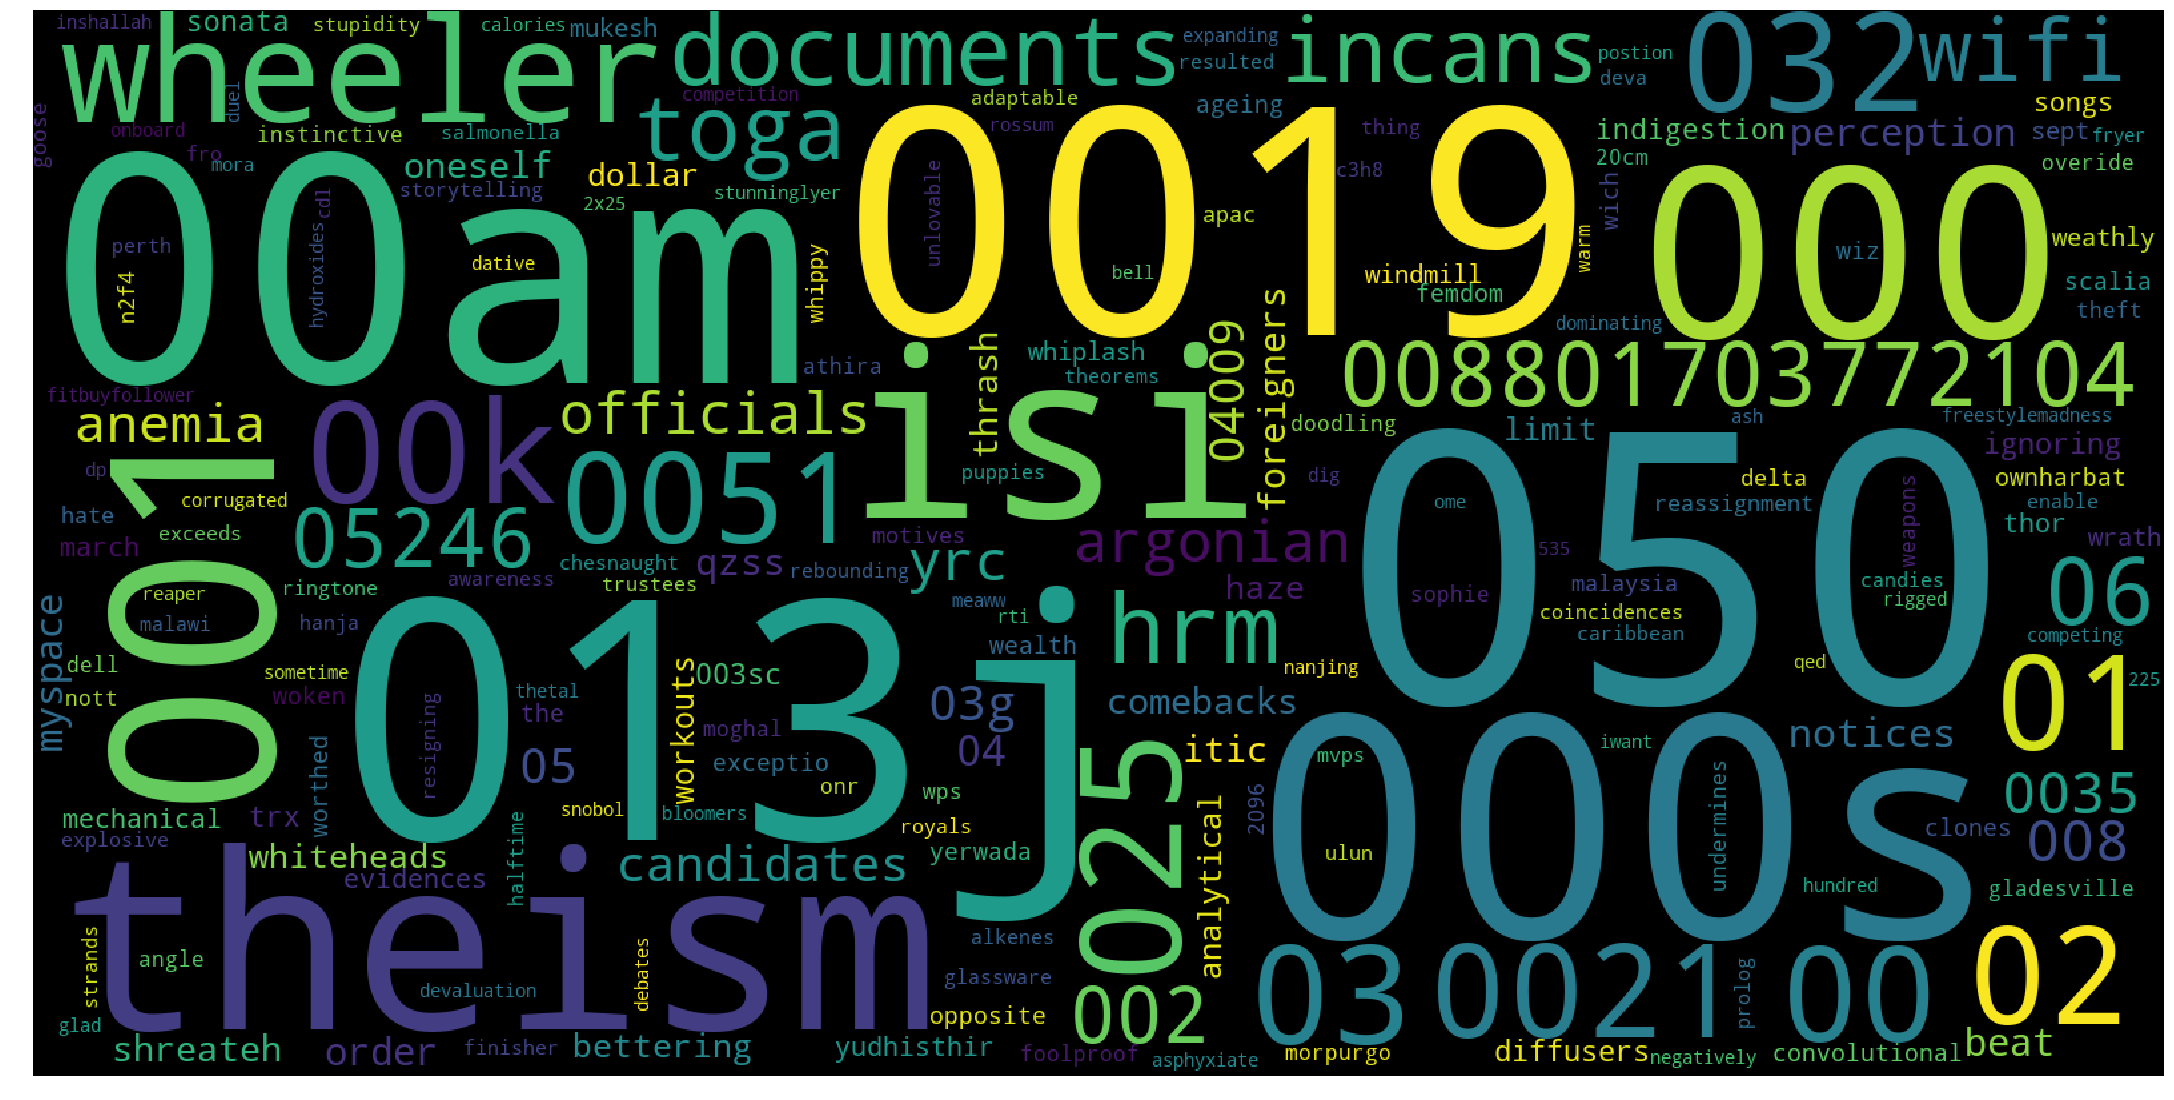

In [99]:
# Ploting word cloud
from wordcloud import WordCloud

freq = fi
words = vect.get_feature_names()
result = dict(zip(words, freq))

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

# 4. Results

In [102]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["MODEL", "Hyperparameters", "Train-log-loss", "Test-log-loss"]

#TFIDFW2V
x.add_row(['TFIDFW2V with Logistic Regression', 'Alpha=0.1', 0.31, 0.45])
x.add_row(['--'*5,'--'*5,'--'*5,'--'*5])
x.add_row(['TFIDFW2V with Linear SVM', 'Alpha=1', 0.36, 0.45])
x.add_row(['--'*5,'--'*5,'--'*5,'--'*5])
x.add_row(['TFIDFW2V with XGBOOST', 'n_estimators = 500 \n Tree-max_depth = 4 \n Learning Rate = 0.2', 0.32, 0.31])
x.add_row(['--'*5,'-'*8,'-'*8,'-'*5])
print(x)

+-----------------------------------+----------------------+----------------+---------------+
|               MODEL               |   Hyperparameters    | Train-log-loss | Test-log-loss |
+-----------------------------------+----------------------+----------------+---------------+
| TFIDFW2V with Logistic Regression |      Alpha=0.1       |      0.31      |      0.45     |
|             ----------            |      ----------      |   ----------   |   ----------  |
|      TFIDFW2V with Linear SVM     |       Alpha=1        |      0.36      |      0.45     |
|             ----------            |      ----------      |   ----------   |   ----------  |
|       TFIDFW2V with XGBOOST       | n_estimators = 500   |      0.32      |      0.31     |
|                                   |  Tree-max_depth = 4  |                |               |
|                                   |  Learning Rate = 0.2 |                |               |
|             ----------            |       --------       |

**OBSERVATION**

Quora Question pair simillarity was trained with 100k points & 20k points with XGboost coz of computation constraints

1. Quora Question pair simmilarity is trained and tested with TFIDF and the results were good.


2. we get a minimal test log loss of 0.2 with GBDT. even when trained with only 20000 points


3. there are chances that XGBoost may perform very well given that we can take whole data into account.


4. though the results are good with TFIDF but XGBoost with TFIDFW2v still wins with test loss of 0.2 and also trained on much lesser data